In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from docs.untitled import fred_api_key
import pandas as pd
import fredapi as fr
from sklearn.preprocessing import MinMaxScaler
import numpy as np




fred = fr.Fred(fred_api_key)




device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

"""Interest Rates(Fed Funds Rate) """

ffr = fred.get_series("FEDFUNDS")
ffr.name = "Fed Funds Rate"

data = pd.DataFrame(ffr).dropna()
data = data.reset_index()
data['Date'] = data['index']


data.drop("index",axis=1,inplace=True)
data.head(10)

cuda:0


,Fed Funds Rate,Date
0,0.80,1954-07-01
1,1.22,1954-08-01
2,1.07,1954-09-01
3,0.85,1954-10-01
4,0.83,1954-11-01
5,1.28,1954-12-01
6,1.39,1955-01-01
7,1.29,1955-02-01
8,1.35,1955-03-01
9,1.43,1955-04-01


In [2]:
data = data.shift(1)
data.dropna(inplace=True)
training = data.iloc[:,0:1].values



train_split = int(len(training) * .88)
train_data = training[:train_split]
test_data = training[train_split:]
print(train_data.shape)
print(test_data.shape)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

def slider(dataframe, seq_length):
    X, y = [], []
    for i in range(len(dataframe) - seq_length - 12):
        X_ = dataframe[i:(i + seq_length)]
        y_ = dataframe[i + seq_length]
        X.append(X_)
        y.append(y_)
    return np.array(X), np.array(y)

seq_length = 1

X_train, y_train = slider(train_data, seq_length)
X_test,y_test = slider(test_data,seq_length)


X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()



class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out



bidirectional_lstm = BiLSTM(input_size=1,hidden_size=64,num_layers=2,output_size=1)
epochs = 500
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=bidirectional_lstm.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

(748, 1)
(103, 1)


In [3]:
for epoch in range(epochs):
    y_pred = bidirectional_lstm(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    bidirectional_lstm.eval()
    with torch.no_grad():
        y_pred = bidirectional_lstm(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  bidirectional_lstm(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')
        

C:\Users\katsa\AppData\Local\Temp\ipykernel_15664\3037039946.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_15664\3037039946.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.3584; Test RSME: 0.171
Epoch: 1; train_RSEM: 0.3485; Test RSME: 0.1617
Epoch: 2; train_RSEM: 0.3388; Test RSME: 0.1525
Epoch: 3; train_RSEM: 0.3291; Test RSME: 0.1437
Epoch: 4; train_RSEM: 0.3194; Test RSME: 0.1352
Epoch: 5; train_RSEM: 0.3098; Test RSME: 0.127
Epoch: 6; train_RSEM: 0.3003; Test RSME: 0.1193
Epoch: 7; train_RSEM: 0.2908; Test RSME: 0.1122
Epoch: 8; train_RSEM: 0.2813; Test RSME: 0.1058
Epoch: 9; train_RSEM: 0.2718; Test RSME: 0.1004
Epoch: 10; train_RSEM: 0.2624; Test RSME: 0.09605
Epoch: 11; train_RSEM: 0.2531; Test RSME: 0.09312
Epoch: 12; train_RSEM: 0.2438; Test RSME: 0.09179
Epoch: 13; train_RSEM: 0.2348; Test RSME: 0.09225
Epoch: 14; train_RSEM: 0.226; Test RSME: 0.09459
Epoch: 15; train_RSEM: 0.2174; Test RSME: 0.09878
Epoch: 16; train_RSEM: 0.2094; Test RSME: 0.1047
Epoch: 17; train_RSEM: 0.2018; Test RSME: 0.1122
Epoch: 18; train_RSEM: 0.195; Test RSME: 0.1209
Epoch: 19; train_RSEM: 0.189; Test RSME: 0.1308
Epoch: 20; train_RSEM: 0.1839

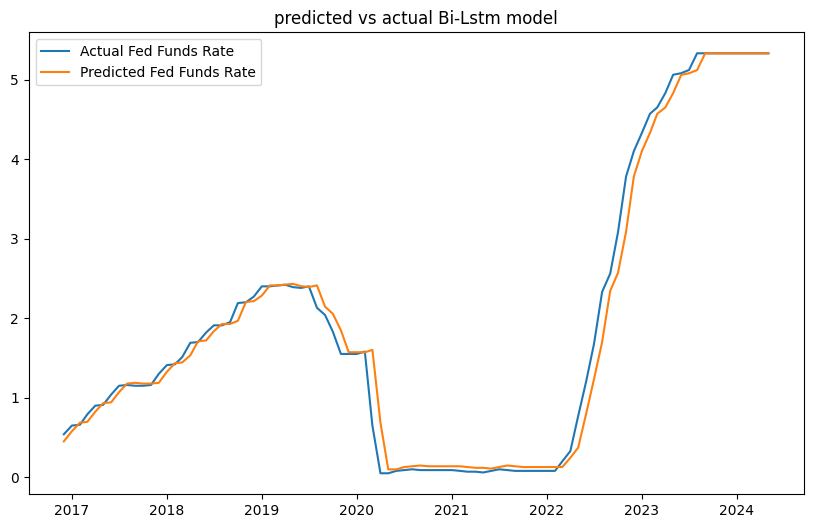

In [4]:
with torch.no_grad():
    pred = bidirectional_lstm(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = data.iloc[train_split + seq_length: -12]['Date']


bilstm_comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Fed Funds Rate": actual_rescaled.flatten(),
    "Predicted Fed Funds Rate":pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(bilstm_comparison_df['Date'],bilstm_comparison_df["Actual Fed Funds Rate"],label="Actual Fed Funds Rate")
plt.plot(bilstm_comparison_df['Date'],bilstm_comparison_df['Predicted Fed Funds Rate'],label="Predicted Fed Funds Rate")
plt.title("predicted vs actual Bi-Lstm model")
plt.legend()
plt.savefig("images/bi_lstm_predicted_vs_actual_fed_funs_rate.png")
plt.show()

In [5]:
print(bilstm_comparison_df.head(20))
print(bilstm_comparison_df.tail(20))

          Date  Actual Fed Funds Rate  Predicted Fed Funds Rate
750 2016-12-01                   0.54                  0.451066
751 2017-01-01                   0.65                  0.578417
752 2017-02-01                   0.66                  0.686264
753 2017-03-01                   0.79                  0.696073
754 2017-04-01                   0.90                  0.823640
755 2017-05-01                   0.91                  0.931666
756 2017-06-01                   1.04                  0.941490
757 2017-07-01                   1.15                  1.069263
758 2017-08-01                   1.16                  1.177459
759 2017-09-01                   1.15                  1.187299
760 2017-10-01                   1.15                  1.177459
761 2017-11-01                   1.16                  1.177459
762 2017-12-01                   1.30                  1.187299
763 2018-01-01                   1.41                  1.325117
764 2018-02-01                   1.42   